In [1]:
!mkdir -p ~/aiffel/fnguide/data
!cp -r ~/data/* ~/aiffel/fnguide/data

# Package Import

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Data Loading

<AxesSubplot:xlabel='time'>

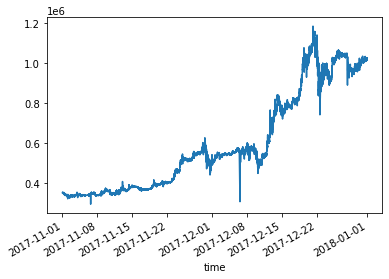

In [3]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

# Data Labeling

Price Change Direction
Using Moving Average
Local Min-Max
Trend Scanning

Price Change Direction
가장 단순한 방식으로 현재 가격과 특정 영업일 이전의 가격의 차이로 Labeling 하는 방식입니다. 간단히 Labeling할 수 있으나, 며칠 전 가격과 비교할 것인지에 따라 변동이 커질 수 있어, 세심한 주의가 필요합니다.

In [4]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

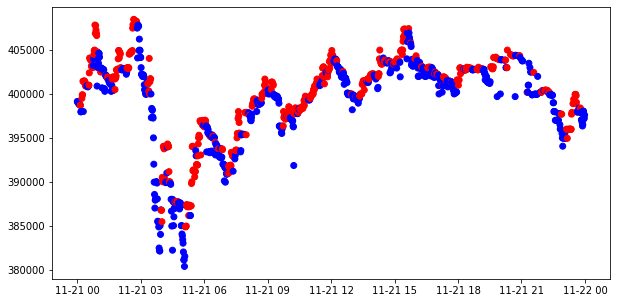

In [5]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

Using Moving Average
기술적 지표를 이용하여 Labeling하는 방식은 여러 가지가 있으나, 여기에서는 이동평균선을 이용한 방식만 간략히 소개하고 넘어가겠습니다. 현재의 주가가 특정 이동평균선 위에 있는지, 아래에 있는지 여부로 Labeling을 하는 방식입니다. 간단히 Labeling할 수 있으나, 가격 차이만으로 Labeling할 경우와 마찬가지로, 이동평균을 며칠로 할 것이냐를 결정하여야 하고, 이동평균으로 인해 Lag(지연)가 발생하게 됩니다.

In [6]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

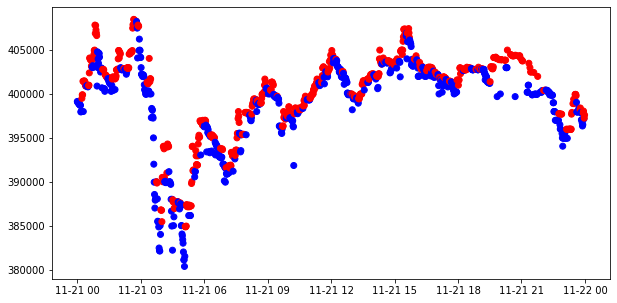

In [7]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

Local Min-Max
이 방식은 국지적인 최소 / 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가며 Labeling하는 방식입니다.
여기서 소개하는 알고리즘만이 정답은 아니며, 국지적 최소 최대를 갱신할 수 있는 여러 방법이 있을 수 있습니다.
현 알고리즘은 계속해서 최소, 최대값을 갱신하다가, 서로 상대방값으로 초기화해 주는 것이 핵심입니다.

예를 들어, 현재 하락구간이어서 최소값이 계속 갱신되고 있다고 가정해 봅시다. 이전 최대값은 3,000원이고, 직전까지 최소값은 2,800원인데, 현재가격이 2,750원으로 더 낮아졌다면, 최소값이 갱신됩니다. 이어서, 다음 가격이 2,800원으로 상승을 시작했다면, 현재 하락구간은 종료되었다는 가정하에 최소값 갱신을 멈추고 이전 최대값을 현재 최소값인 2,750원으로 변경해 주어 앞으로 상승구간에서 최대값 갱신이 가능하도록 조정합니다.
여기서, 현재가격이 한번 상승했다고 바로 하락구간 종료를 가정하면, 빈번한 Labeling의 변화가 있을 수 있으므로, 좀 더 변동이 적은 작업을 위해 Wait 계수를 설정할 수 있습니다. 상승구간에서의 과정도 하락구간과 동일합니다.

이 방식은 순차적 가격 확인이 요구되는 만큼 데이터가 증가하면, 선형적으로 연산시간도 늘어나는 단점이 있습니다. 또한, 앞선 방식들과 마찬가지로 Wait 계수를 작게하면 변동성이 커질 수 있으므로, 신중한 계수선택이 요구됩니다.

In [8]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [10]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

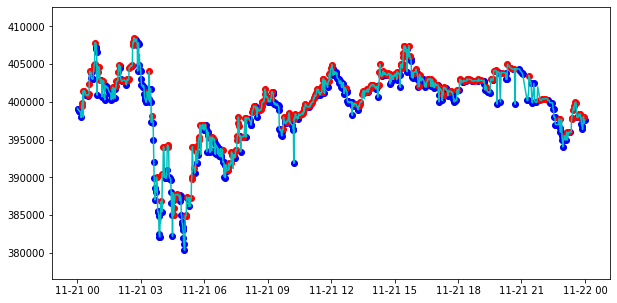

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

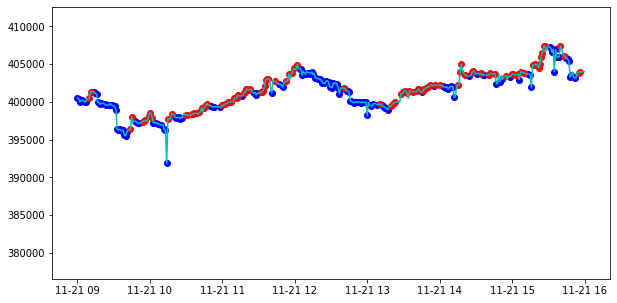

In [12]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [13]:
mins.shape[0], maxes.shape[0]

(477, 273)

Trend Scanning
Trend Scanning은 Marcos Lopez de Prado 의 저서 'Machine Learning for Asset Managers'에 소개된 Labeling 방식입니다.
시계열 데이터 X𝑡가 주식 또는 코인의 가격이라고 가정해 봅시다. 현재 𝑡 시점에서 𝑡+𝑙 시점까지의 회귀식을 Fitting하여, 𝛽 값을 구합니다. 이 𝛽 값의 𝑡𝑣𝑎𝑙𝑢𝑒 를 구합니다. max𝑡𝑣𝑎𝑙𝑢𝑒 의 부호를 통해 Labeling을 진행합니다.

T-value란?
두 대상이 평균적으로 얼마나 차이가 나는가를 표현한 정도를 나타낼 수 있습니다. t-value 값이 클수록 두 대상의 평균의 차이는 크다고 할 수 있습니다. t-value는 두 대상을 '평균적'으로 비교하고 싶을 때 사용합니다. 
예시로 내가 세운 가설로 계산한 주가와 실제 주가는 평균적으로 큰 차이가 있을까? 가설로 구한 주가와 실제 주가의 t-value가 0에서 멀다면 가설로 구한 주가와 실제 주가는 차이가 크다고 비교해 볼 수 있습니다.

In [14]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [15]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [16]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:34<00:00, 40.97it/s]


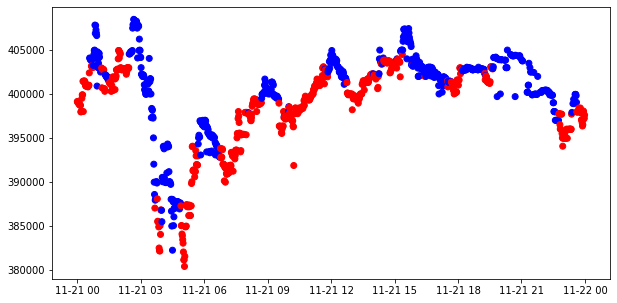

In [17]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])